# Self-Organising Maps, the yhat tutorial
[Source](http://blog.yhat.com/posts/self-organizing-maps-2.html)

Our goal will be to map 3D vectors representing R,G,B to 2D maps with SOM.

### Dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

In [2]:
raw_data = np.random.randint(0, 255, (3, 100))

### Setup
Setup the grid by creating a 5x5 array of random 3D weight vectors

In [3]:
network_dimensions = np.array([5,5])
n_iterations = 4000
init_learning_rate = 0.01

m = raw_data.shape[0]
n = raw_data.shape[1]

# weight matrix need to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

In [4]:
# iniital neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1])/2

# radius decay parameter
time_constant = n_iterations /np.log(init_radius)

### Normalisation

In [5]:
normalise_data = True

# if True, assume all data is on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

# we want to keep a copy of the raw data for later
data = raw_data

# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        data = raw_data / data.max()

### Learning

1. Define functions

In [6]:
def find_bmu(t, net, m):
    bmu_idx = np.array([0,0])
    min_dist = np.iinfo(np.int).max
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :]
            sq_dist = np.sum((w-t)**2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x,y])
                
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    return bmu, bmu_idx

In [7]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [8]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

## SOM Learning
Here the data are randomly chosen without the notion of epochs.

In [9]:
for i in range(n_iterations):
    t = data[:, np.random.randint(0,n)].reshape(np.array([m, 1]))
    
    bmu, bmu_idx = find_bmu(t, net, m)
    
    r = decay_radius(init_radius, i,time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector and move its neighbour's
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            w_dist = np.sum((np.array([x,y])-bmu_idx)**2)
            if w_dist <= r**2:
                influence = calculate_influence(w_dist, r)
                new_w = w + (l*influence*(t-w))
                net[x, y, :] = new_w.reshape(1, m)

### Plot

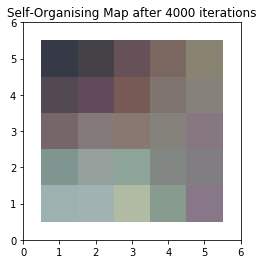

In [10]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()